# **PART 3:** TCRex results & statistics

In [141]:
import os
# Set the working directory to the repository directory
os.chdir("/home/sebastiaan/PhD/Repositories/book_chapter/")

Once again, we will need the `pandas` library for handling the data. In addition, this part of the tutorial requires the `scipy`  and `statsmodels` libraries.

In [ ]:
import pandas as pd
import scipy

from statsmodels.stats.multitest import multipletests

We start by defining two functions for processing the TCRex results. The first function will be used to read the data correctly. The second function will combine the different chunks originating from the same file back together. 

In [144]:
def read_results(folder, file):
    
    """
    Read in a TCRex results file as a pandas dataframe. 
    Ignores meta data information preceded with a '#' sign.
    
    Args:
    - folder: The folder where the TCRex results file is located
    - file: The name of the TCRex results file
    """
    return pd.read_csv(os.path.join(folder, fn), sep = "\t", comment = "#")


def concatenate_data(folder, name):
    
    """
    Concatenate TCRex results from different files into one file.
    
    Args:
    - folder: Path to the directory where the folder with the TCRex results files are located.
    - name: Name of the folder holding all the TCRex results file that need to be concatenated.
    """

    # Get a list of all files in the folder
    files = os.listdir(folder)
        
    # Concatenate all dataframes in the results list
    all_results = pd.concat(
        objs = [read_results(folder, fn) for fn in files]
        )

    # Save concatenated dataframe in a new folder
    new_folder = '../results/parsed_results'
    new_file = os.path.join(new_folder, '.'.join([name,'tsv']))
    
    # If new folder does not exist, create it
    if not os.path.exists(new_folder):
            os.mkdir(new_folder)
    
    # Write results to a new file
    all_results.to_csv(new_file, sep = '\t', index = False)
    

Now we can apply the `concatenate_data` function that we just wrote to combine the chunks from the same file.

In [146]:
concatenate_data(os.path.join('../results/test'), 'filename')

We will perform a simple quantitative evaluation of the TCRex prediction results by calculating the identification rate and an enrichment score for a certain epitope. The identification rate describes the percentage of epitope-specific TCRs TCRex found in a repertoire (i.e. the number of TCRs for which a hit was found). To calculate the enrichment score, we perform a one-sided binomial test to assess significant overrepresentation (enrichment) of a particular epitope in a sample.

In [ ]:
def identification_rate(nr_identified, repertoire_size):
    
    """
    Calculate the percentage of epitope-specific TCRs in a repertoire.
    
    Args:
    - nr_identified: The number of identified epitope-specific TCRs 
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    
    """
    return (nr_identified / repertoire_size) * 100

def enrichment_analysis(
    nr_identified: int, 
    repertoire_size: int, 
    threshold: float = 0.001
    ):
    
     """
     Calculate the p value of a one sided binomial test.
     
     Args:
     - nr_identified:  The number of identified epitope-specific TCRs 
     - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
     - enrichment_threshold: Probability of success as defined in a binomial test.
     
     """ 
    return scipy.stats.binom_test(
         x = nr_identified, 
         n = repertoire_size,
         p = threshold,
         alternative = 'greater'
         )

Using the following sequence of commands, we can calculate the quantitative metrics that we defined previously. That is, for a single epitope.

In [147]:
# Read the resuls
results = pd.read_csv(os.path.join('../results/parsed_results','test.tsv'), sep = '\t')

# Calculate the number of identified epitope-specific TCRs 
nr_identified = results.shape[0]  

# Define the repertoire size
repertoire_size = 100000

p = enrichment_analysis(nr_identified, repertoire_size) # p-value
ir = identification_rate(nr_identified, repertoire_size) # identification rate

# Calculate the identification metrics
print(f"p value: {p}"
print(f"Identification rate: {ir}")

0.037

Most of the time, however, we use multiple TCRex epitope models. Therefore, we should calculate the enrichment score for each epitope individually. The following function does this by looping through every epitope in the results file.

In [10]:
def calculate_metrics(
    results: pd.DataFrame, 
    repertoire_size: int, 
    threshold: float,
    mtc: bool = True
    ):
    """
    Calculate the identification rate and enrichment analysis p value for every epitope in a TCRex results file.
    
    Args:
    - results: Pandas DataFrame containing the TCRex results
    - repertoire_size: The number of TCRs in the original repertoire, reported on the TCRex results page
    - enrichment_threshold: Probability of success as defined in a binomial test.
    - mtc: p-value correction for multiple tests using Benjamini-Hochberg method for controlling FDR.
    """
    # For every epitope, store the calculated metrics in a dictionary
    cols = ["identification_rate", "p_value"]
    metrics = pd.DataFrame(columns = cols)
    
    # Loop through epitopes
    for epitope in results.epitpope.unique():
        # Retrieve all TCRs specific for the epitope
        epitope_data = results[results['epitope'] == epitope]
        # Calculate the number of epitope-specific TCRs
        nr_identified = epitope_data.shape[0]
        # Calculate metrics
        ir = identification_rate(nr_identified, repertoire_size)
        p = enrichment_analysis(nr_identified, repertoire_size, threshold)
        # Add to dataframe
        metrics = pd.concat([metrics, pd.DataFrame([[ir, p]], columns = cols)])
        
    if mtc:
        # Calculate corrected p-values
        p_adj = multipletests(
            pvals = metrics.p_value, 
            method = 'fdr_bh', 
            is_sorted = False
            )[1]
        # Add to dataframe
        metrics['adjusted_p_value'] = p_adj
        
    return metrics 

Finally, we can put all this together and calculate some the statistics we just defined for every individual epitope for which we screened.

In [149]:
# Read the resuls
results = read_results(os.path.join(base_dir,'results'), 'multiple.tsv')
# Calculate metrics for epitopes
metrics_df = calculate_metrics(
    results = results,
    repertoire_size = 10000,
    threshold = 0.0001
    )
# Show results
metrics_df.head()

,identification_rate,p_value
QYDPVAALF,0.16,1.848163e-14
QIKVRVKMV,0.14,4.484526e-12
YSEHPTFTSQY,0.41,1.041819e-50
NLVPMVATV,27.13,0.000000e+00
IPSINVHHY,0.13,6.317656e-11
VTEHDTLLY,0.96,2.394793e-151
TPRVTGGGAM,0.27,3.391162e-29


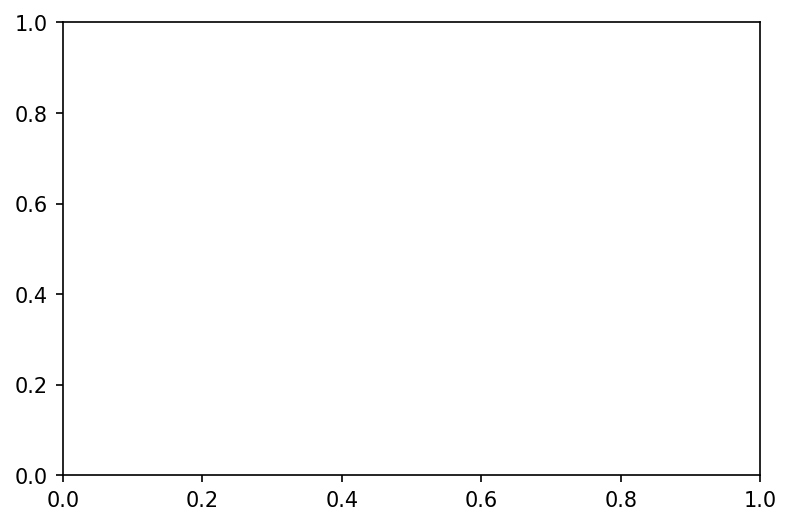

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 150)
# ax.barplot()

In [12]:
# ADD BAR CHART OF EPITOPES COLORED ACCORDING TO ENRICHMENT SCORE?